In [1]:
%matplotlib inline
%run 'bin/notebook_utils.py'
%run 'bin/plot_utilization.py'
import matplotlib.ticker as mticker
import radical.entk as re

In [2]:
! radical-stack


  python               : 3.7.6
  pythonpath           : 
  virtualenv           : base

  radical.analytics    : 0.90.7
  radical.entk         : 1.4.0
  radical.pilot        : 1.4.1
  radical.saga         : 1.4.0
  radical.utils        : 1.4.0



In [3]:
suds = ['re.session.login3.litan.018460.0010', 're.session.login1.litan.018465.0001']
sdir = '../data/raw/'
sids = [sdir+s for s in suds]

In [4]:
ss = {}
for sid in suds:
    sp = sdir+sid
    ss[sid] = {'s': ra.Session(sp, 'radical.pilot')}
    ss[sid].update({'p': ss[sid]['s'].filter(etype='pilot'   , inplace=False),
                    'u': ss[sid]['s'].filter(etype='unit'    , inplace=False),
                    't': ss[sid]['s'].filter(etype='task'    , inplace=False),
                    'w': ss[sid]['s'].filter(etype='pipeline', inplace=False)})

session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded


session loaded


In [5]:
for sid in suds:
    ss[sid].update({'sid'   : ss[sid]['s'].uid,
                    'pid'   : ss[sid]['p'].list('uid'),
                    'npilot': len(ss[sid]['p'].get()),
                    'lm'    : ss[sid]['s'].get(etype='pilot')[0].cfg['agent_launch_method'],
                    'npact' : len(ss[sid]['p'].timestamps(state='PMGR_ACTIVE')),
                    'nunit' : len(ss[sid]['u'].get()),
                    'nudone': len(ss[sid]['u'].timestamps(state='DONE')),
                    'nufail': len(ss[sid]['u'].timestamps(state='FAILED'))})
    ss[sid].update({'pres'  : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['resource'],
                    'ncores': ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['cores'],
                    'ngpus' : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['gpus']})                  
    ss[sid].update({'nnodes': ss[sid]['ngpus']/6})

In [6]:
for sid in suds:
    print("""
%s:
\tName of the HPC platform: %s
\tPilot launch method: %s
\tNumber of pilots requested: %i
\tNumber of pilots active: %i
\tNumber of requested cores: %i
\tNumber of requested GPUs: %s
\tNumber of requested nodes: %s
\tNumber of nodes asked by ENTK: %i
\tNumber of tasks executed by EnTK: %i
\tNumber of tasks successfully executed by EnTK: %i
\tNumber of failed tasks: %i
""" % (sid              , ss[sid]['pres']  , ss[sid]['lm'], 
       ss[sid]['npilot'], ss[sid]['npact'] , ss[sid]['ncores']/4, 
       ss[sid]['ngpus'] , ss[sid]['nnodes'], ss[sid]['ncores']/168, 
       ss[sid]['nunit'] , ss[sid]['nudone'], ss[sid]['nufail']))


re.session.login3.litan.018460.0010:
	Name of the HPC platform: ornl.summit
	Pilot launch method: JSRUN
	Number of pilots requested: 1
	Number of pilots active: 1
	Number of requested cores: 5376
	Number of requested GPUs: 768
	Number of requested nodes: 128.0
	Number of nodes asked by ENTK: 128
	Number of tasks executed by EnTK: 100
	Number of tasks successfully executed by EnTK: 100
	Number of failed tasks: 0


re.session.login1.litan.018465.0001:
	Name of the HPC platform: ornl.summit
	Pilot launch method: JSRUN
	Number of pilots requested: 1
	Number of pilots active: 1
	Number of requested cores: 10752
	Number of requested GPUs: 1536
	Number of requested nodes: 256.0
	Number of nodes asked by ENTK: 256
	Number of tasks executed by EnTK: 300
	Number of tasks successfully executed by EnTK: 300
	Number of failed tasks: 0



In [7]:
for sid in suds:
    w  = ss[sid]['w']
    u  = ss[sid]['u']
    t  = ss[sid]['t']
    p  = ss[sid]['p']
    p0 = p.get(uid=ss[sid]['pid'])[0]

    ss[sid].update({
      'ttc'  : p0.duration(event=[ {ru.EVENT: 'state'        , ru.STATE: rp.NEW                }, 
                                  [{ru.EVENT: 'state'        , ru.STATE: re.states.COMPLETED   },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.CANCELED    },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.FAILED      }]]),
      'ttq_p': p0.duration(event=[ {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE_PENDING}, 
                                   {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE        } ]),
      'ttx_w': w.duration( event=[ {ru.EVENT: 'state'        , ru.STATE: re.states.SCHEDULING  },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.DONE        } ]),
      'ttx_p': p0.duration(event=[ {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE        },
                                  [{ru.EVENT: 'state'        , ru.STATE: rp.DONE               },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.FAILED             },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED           }]]),
      'sub_t': t.duration( event=[ {ru.EVENT: 'state'        , ru.STATE: re.states.SCHEDULING  },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.SUBMITTING  } ]),
      'ttx_t': t.duration( event=[ {ru.EVENT: 'state'        , ru.STATE: re.states.SUBMITTING  },
                                  [{ru.EVENT: 'state'        , ru.STATE: re.states.COMPLETED   },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.CANCELED    },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.FAILED      }]]),
      'ttx_u': u.duration( event=[ {ru.EVENT: 'cu_exec_start', ru.STATE: None                  },      
                                   {ru.EVENT: 'cu_exec_stop' , ru.STATE: None                  } ]),
      'pilot_lifetime': p.duration(event=[{ru.EVENT: 'bootstrap_0_start', ru.STATE: None},
                                          {ru.EVENT: 'bootstrap_0_stop', ru.STATE: None}])})
    
    ss[sid].update({'ovh_rtc': ss[sid]['pilot_lifetime'] - ss[sid]['ttx_u']})

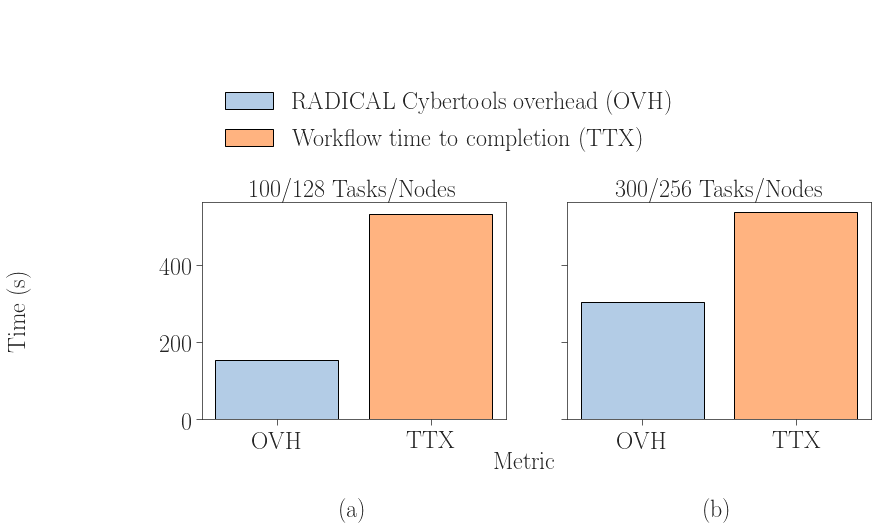

In [13]:
fwidth = 6*len(suds)
fhight = 4
fig, axarr = plt.subplots(1, len(suds), sharey=True, figsize=(fwidth, fhight))

i = 0
j = 'a'
for sid in suds:
    if len(suds) > 1:
        ax = axarr[i]
    else:
        ax = axarr
    
    ax.title.set_text('%s/%s Tasks/Nodes' % (ss[sid]['nunit'], int(ss[sid]['nnodes'])))

    ax.bar(x = 'OVH', height = ss[sid]['ovh_rtc'], color = tableau20[1])
    ax.bar(x = 'TTX', height = ss[sid]['ttx_u']  , color = tableau20[3])

    ax.set_xlabel('(%s)' % j, labelpad=45)

    i = i+1
    j = chr(ord(j) + 1)

fig.text(-0.1,  0.5 , 'Time (s)', va='center', rotation='vertical', fontsize=24)
fig.text( 0.5, -0.05, 'Metric'  , ha='center', fontsize=24)
fig.legend(['RADICAL Cybertools overhead (OVH)', 'Workflow time to completion (TTX)'], loc='upper center', 
           bbox_to_anchor=(0.52, 1.6), fontsize=24, ncol=1)
    
plt.savefig('figures/incite2020_ovh_ttx.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/incite2020_ovh_ttx.png', dpi=300, bbox_inches='tight')